In [ ]:
#In this worksheet we're checking and comparing various estimates of sensitivity
# psa32 Parsons sensitivity (analytic)
#  1.5e3mK^2   @ k=0.3, z=7.7 
# psa64 Ali sensitivity (analytic) :  
#  0.9e3 mK^2 @ k=0.3, z=8.4
# psa64 Jacobs sensitivity (21cmsense):
#  5e3 mK^2 @ k=0.3, z=8.4
#### from below ######
# psa64 analytic 
#  0.9e3 mK^2   @ k=0.3, z=8.4  #single bl 
#  1.1e3 mK^2   @ k=0.3, z=8.4 #3 bls, 2 sigma 
# psa64 21cmsense recalculation 
#  15.1e3 mK^2  @ k=0.3, z=8.4  #single EW 30m baseline.
#  17e3 mK^2    @ k=0.3, z=8.4  #scaled to 3bls and 2sigma
# psa64 noise simulation
# MY ESTIMATE OF I DEPENDS ON the PROBABILITY, THIS NEEDS CHECKING
#  5.6e3 mK^2  @ k=0.3, z=8.4  #with only 1 EW 30m baseline
#  6.9e3 mK^2  @ k=0.3, z=8.4  #scaled to 3bls and 2sigma

In [2]:
%matplotlib inline
import numpy as np
from pylab import *

In [190]:
import capo
print "X2Y = ",capo.pspec.X2Y(8.4)/1e9
print "Omega_eff as used to convert visibilities in mK to Pk:",np.polyval(capo.pspec.DEFAULT_BEAM_POLY,0.151)*2.35 

X2Y =  515.138214473
Omega_eff as used to convert visibilities in mK to Pk: 1.69134622694


In [137]:
class Sense(object):
    def __init__(self):
        self.Tsys = 0 #mK!
        self.Omega_eff = 1.7 #Ali et al (taken from Zaki's evernote)
        #self.Omega_eff = 1.74 #recalculation with capo/dcj/scripts/beam_integral.py  Omega_p^2/Omega_pp, per Appendix B of Parsons psa32 
        #check for FRF effective beam.
        #self.Omega_eff = 0.51**2/0.24  #effective beams if using FRF, taken from Table 1 of Parsons 2015 "beam sculpting paper"
        self.t_int = 0
        self.Npols = 2
        self.X2Y = 515  #z=8.4
        self.Ndays = 0
        self.Nlsthours = 0
        self.Nbls = 0
        self.P_N = None
        self.Nseps = 0
        self.Nreal = 2
        self.Nlstbins = None
        return
    def calc(self):
        if self.Nlstbins is None: self.Nlstbins = self.Nlsthours*3600/self.t_int
        self.P_N = self.X2Y * self.Omega_eff * self.Tsys**2 
        self.P_N /=(2*self.Nreal*self.t_int * self.Ndays * self.Nbls * self.Npols * np.sqrt(self.Nlstbins))
        self.P_N /= np.sqrt(2) #fold in k//
        self.P_N /= np.sqrt(self.Nseps)
    def Delta2_N(self,k):
        if self.P_N is None: print("noise undefined until first Sense.calc()"); return 0
        return self.P_N * k**3/(2*np.pi**2)

In [185]:
S = Sense()
S.Tsys = 551e3  #set to match 21cmsense exactly 
#S.Tsys = 486e3 #(200K + 180(150/180)^-2.55)
#S.Tsys = 505e3 #Ali et al, at 164MHz
#S.t_int = 3414 # python ~/scripts/frf_diagnose.py -C psa6240_v003 --seps=0,1 -pxx; returns T_eff = 3414s (NEBW)
S.t_int = 440   # approximate longest time possible for 30m bl without frf, 
#                t_int=440 is taken from Table 1 of Parsons 2015, beam paper, roughly matches the uv bin occupation time in 21cmsense
S.Ndays = 65
S.Nlsthours = 8.5
#S.Nlstbins = 9
S.Nbls = 51
S.Nseps = 3
S.calc()
print "\Delta^2(k=0.2) = ",S.Delta2_N(0.3)*2 #2sigma

\Delta^2(k=0.2) =  3050.61337817


0.82
number of seconds in the best sampled uv pixel 443.257881599
number of pixels like this 6
the length of the observation is  1.4578259217 hours
number of independent modes =  19.0
assuming we want 9 LST hours, n_per_day should be 6.17357660199


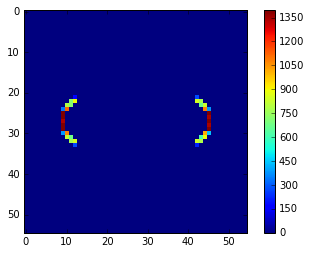

In [158]:
#take a look at the uv coverage in 21cmsense, verify that we're only simulating a single baseline
C = np.load('psa6240_v003drift_blmin0_blmax23_arrayfile.npz')
print C['dish_size_in_lambda']
imshow(C['uv_coverage'],interpolation='nearest')
colorbar()
print "number of seconds in the best sampled uv pixel", C['uv_coverage'].max()*60/65/np.sqrt(8.5)
cnt = C['uv_coverage']*60/65/np.sqrt(8.5)
print "number of pixels like this",np.sum(cnt>442)
print "the length of the observation is ",np.sum(cnt)/2/3600,"hours"
print 'number of independent modes = ',np.sum(cnt>1)/2.
print "assuming we want 9 LST hours, n_per_day should be", 9/(np.sum(cnt)/2/3600)


In [179]:
#load the 21cmsense calculation whichshould nominally match
# /Users/djacobs/Work/radio_astronomy/Papers/psa64_multiz/data/21cmSense
# ./mk_array_file.py -C psa6240_v003 --bl_max=45  #NB this mk_array is hacked to exclude all but 0,1EW bls
# ./calc_sense.py  --nchan=21 --bwidth=0.010 --n_per_day=6.17 --ndays=65  -f 0.150 --no_ns psa6240_v003drift_blmin0_blmax23_arrayfile.npz -m pess
#     'dish_size_in_lambda' : 0.87, #in units of wavelengths, effective dish size calculated with capo/dcj/scripts/beam_integral.py
#     'Trx' : 200e3, #receiver temp in mK
#      n_per_day :  estimated by calculating the length of the track to be 1.5 hours (looking at the uv plane above) 
#                   and a desired total of 8.5 hours
F = np.load('psa6240_v003drift_pess_0.150.npz')
print "k=",F['ks'][5]
print "\Delta^2(k=0.3) = ",F['T_errs'][5]
print "scaled to match Zaki,",F['T_errs'][5]/np.sqrt(3)*2 #scaled from 1 to 3 bls and 2 sigma

k= 0.303470726629
\Delta^2(k=0.3) =  7183.71610155
scaled to match Zaki, 8295.04085002


In [171]:
#new pspec pipeline same noise realization as above
P = np.load('pspec_final_confidence_85.npz')
print "k = ",P['k'][6]
print "\Delta^2(k=0.3) = ",P['pI_fold_up'][6]/np.sqrt(3)*2 #scaled from 1 to 3 bls and 2 sigma

k =  0.295892574198
\Delta^2(k=0.3) =  20102.0828769


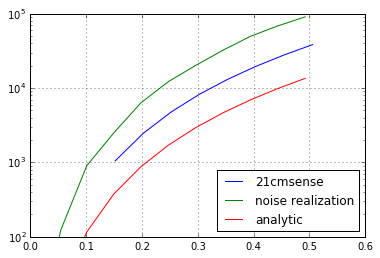

In [191]:
#plot a comparison between the noise run and the 21cmsense run
#all plotted as 2 sigma for 3 seperations
#goal is for everyone to match the 21cmsense
semilogy(F['ks'],F['T_errs']/np.sqrt(3)*2,label='21cmsense')
semilogy(P['k'],P['pI_fold_up']/np.sqrt(3)*2,label='noise realization')
semilogy(P['k'],S.Delta2_N(P['k'])*2,label='analytic')
legend(loc='best')
ylim(1e2,1e5)
grid()